### Figure: Role of the open ocean in setting inter-annual variability

In [105]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from xhistogram.xarray import histogram as hist
import statsmodels.formula.api as sm

In [2]:
# Universal variables
rootdir = 'data/'
yrst = 1958
yrinit = 1976
yrend = 2016
years = np.arange(yrst,yrend+1,1)
years_c = 0.5*(years[:-1]+years[1:])
years_init = np.arange(yrinit,yrend+1,1)
years_init_c = 0.5*(years_init[:-1]+years_init[1:])
bathys = np.array([1,40,51,60,65,76])
bathys_c = 0.5*(bathys[:-1]+bathys[1:])

In [12]:
# Load bathymetry
filepath_zgrid = rootdir+'raw/mesh_zgr.nc'
zgrid = xr.open_dataset(filepath_zgrid).squeeze()
# Load volumetric distribution of subduction location and age from ariane output
filepath_vlag = rootdir+'processed/lagrangian/D4_weights-init_volume_bins-final_x-final_y-final_age-init_t_subset-final_section-7.nc'
vlag = xr.open_dataarray(filepath_vlag)
# Get the Lagrangian data and the grid data on the same grid
# Assign coordinates
zgrid = zgrid.assign_coords({'x':range(1,zgrid.x.size+1),'y':range(1,zgrid.y.size+1)})
depth = np.round(zgrid['gdept_0'].isel(final_x_bin=0,final_y_bin=0)
# Subset grid to region_limits
xmask = (zgrid.x>=np.floor(vlag.final_x_bin.min())) & (zgrid.x<np.ceil(vlag.final_x_bin.max()))
ymask = (zgrid.y>=np.floor(vlag.final_y_bin.min())) & (zgrid.y<np.ceil(vlag.final_y_bin.max()))
zgrid = zgrid.where(xmask & ymask,drop=True)
# Make consistent with lagrangian output
zgrid = zgrid.rename({'x':'final_x_bin','y':'final_y_bin'})
zgrid = zgrid.assign_coords({'final_x_bin':vlag.final_x_bin,'final_y_bin':vlag.final_y_bin})
# Propoagate bathymetry data across time and merge datasets
zgrid['mbathy'] = zgrid.mbathy*xr.ones_like(vlag)
vlag = xr.merge([vlag,zgrid.mbathy])

# Load volumetric distribution of age from ariane output
filepath_vlag_all = rootdir+'processed/lagrangian/D2_weights-init_volume_bins-final_age-init_t_subset-final_section-7_alt.nc'
vlag_all = xr.open_dataarray(filepath_vlag_all)
                 
# Load NAO data
filepath_nao = rootdir+'raw/nao_station_djfm.txt'
nao_vals = np.loadtxt(filepath_nao,skiprows=1)[:,1]
nao_years = np.loadtxt(filepath_nao,skiprows=1)[:,0]+0.5
nao = xr.DataArray(nao_vals,dims=['years'],coords={'years':nao_years})
nao = nao.sel(years=slice(yrst,yrend))
# Load mixed layer volume from model
# This is the summed volume in the mixed layer north of 45N as defined by the somxl010 variable
# Evaluated in Feb-Mar-Apr of each year
# See calc_Vmld.py for details of calculation
filepath_mld = rootdir+'processed/eulerian/orca025_NA_Vmld.nc'
vmld = xr.open_dataarray(filepath_mld)

In [89]:
# PROCESS EULERIAN DATA
# Group data by years and take the mean
vmld_byyear = vmld.groupby(vmld.time_counter.dt.year,years).mean(dim='time_counter')
# Calculate annual anomaly
vmld_anom = vmld_byyear-vmld_byyear.mean('year')

In [14]:
# PROCESS LAGRANGIAN DATA
# Histogram the distribution according to the bathymetry of the subduction location
vlag_bathy = hist(vlag.mbathy,
                  bins=[bathys],
                  dim=['final_x_bin','final_y_bin'],
                  weights=vlag.init_volume)

In [68]:
# Age anomaly
# Get mean volume distribution as a function of age [all bathymetries]
vlag_itmean = vlag_all.where(vlag_all!=0).mean('init_t_bin')
# Now mean as a function of bathymetry
vlag_bathy_itmean = vlag_bathy.where(vlag_bathy!=0).mean('init_t_bin')
vlag_bathy_anom = (vlag_bathy.isel(init_t_bin=-1)-vlag_bathy_itmean)/vlag_all_itmean # Note that division is by the mean 'total volume' at that age
# Rebrand coord as year
vlag_bathy_anom = vlag_bathy_anom.rename(
    {'final_age_bin':'final_year_bin'}).assign_coords(
    final_year_bin=np.flip(years_c))

In [101]:
# Put desired variables into a pandas dataframe
# Subset variables for particular years and put them into a pandas dataframe
ys = slice(1976,2016)
ys_r = slice(2016,1976)
ags = slice(0,2016-1976)

years_vals = years_init_c
# Eulerian
nao_vals = nao.sel(years=ys).values
vmld_vals = vmld_anom.sel(year=ys).values


df = pd.DataFrame({'years':years_vals,'nao':nao_vals,'vmld_anom':vmld_vals,
                   '20.5':np.flip(vlag_bathy_anom.sel(mbathy_bin=20.5,final_year_bin=ys_r).values),
                  '45.5':np.flip(vlag_bathy_anom.sel(mbathy_bin=45.5,final_year_bin=ys_r).values),
                  '55.5':np.flip(vlag_bathy_anom.sel(mbathy_bin=55.5,final_year_bin=ys_r).values),
                  '62.5':np.flip(vlag_bathy_anom.sel(mbathy_bin=62.5,final_year_bin=ys_r).values),
                  '70.5':np.flip(vlag_bathy_anom.sel(mbathy_bin=70.5,final_year_bin=ys_r).values)})

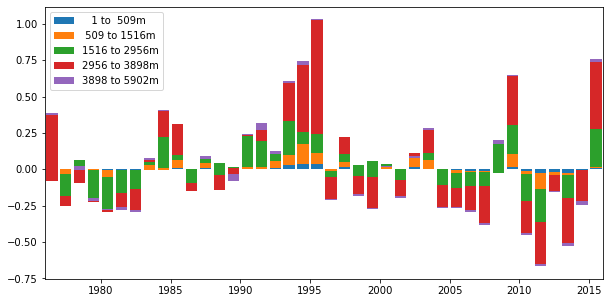

In [102]:
fig,ax0 = plt.subplots(figsize=(10,5))
xlims = [yrst+18,yrend]
bottom = np.zeros(shape=(len(df['years'])))
count=0
for b in bathys_c:
    if b==bathys_c[-1]:
        # Because range of bathys designed to capture all levels, need to taper in lat value
        depthrange = str('{:4.0f}'.format(depth[bathys[count]-1].values))+' to '+str('{:4.0f}'.format(depth[bathys[count+1]-2].values)+'m')
    else:
        depthrange = str('{:4.0f}'.format(depth[bathys[count]-1].values))+' to '+str('{:4.0f}'.format(depth[bathys[count+1]-1].values)+'m')
        count+=1
        
    ax0.bar(df['years'],df[str(b)],bottom=bottom,label=depthrange)
    bottom += df[str(b)]
ax0.set_xlim(xlims)
ax0.legend()

Text(0, 0.5, 'Volume [$10^{15}\\,m^3$]')

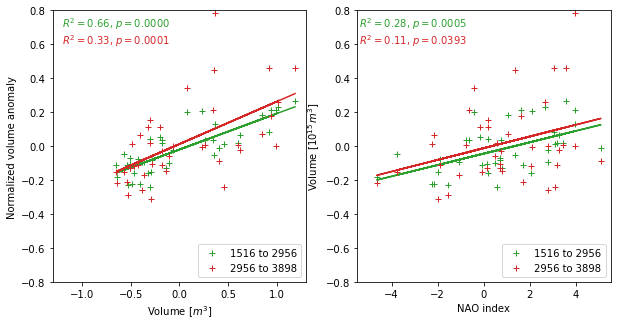

In [123]:
## PANEL: Regression (mixed layer volume anomaly)
xlims=[-1.3,1.3]
ylims = [-0.8,0.8]
color_b1 = 'tab:green'
color_b2 = 'tab:red'

fig,(ax_regress1,ax_regress2) = plt.subplots(figsize=(10,5),ncols=2)

result = sm.ols(formula='Q("55.5") ~ vmld_anom', data=df).fit()
ax_regress1.plot(1E-15*df['vmld_anom'],df['55.5'],'+',color=color_b1,label='1516 to 2956')
ax_regress1.plot(1E-15*df['vmld_anom'],result.params.Intercept+result.params.vmld_anom*df['vmld_anom'],'-',color=color_b1)
ax_regress1.text(xlims[0]+0.1,ylims[1]-0.1,
                 '$R^2 = $'+str('{0:.2f}'.format(result.rsquared))+', $p = $'+str('{0:.4f}'.format(result.f_pvalue)),
                 color=color_b1)
result = sm.ols(formula='Q("62.5") ~ vmld_anom', data=df).fit()
ax_regress1.plot(1E-15*df['vmld_anom'],df['62.5'],'+',color=color_b2,label='2956 to 3898')
ax_regress1.plot(1E-15*df['vmld_anom'],result.params.Intercept+result.params.vmld_anom*df['vmld_anom'],'-',color=color_b2)
ax_regress1.text(xlims[0]+0.1,ylims[1]-0.2,
                 '$R^2 = $'+str('{0:.2f}'.format(result.rsquared))+', $p = $'+str('{0:.4f}'.format(result.f_pvalue)),
                 color=color_b2)

ax_regress1.legend(loc='lower right')
ax_regress1.set_xlim(xlims)
ax_regress1.set_xlabel('Volume [$m^3$]')
ax_regress1.set_ylim(ylims)
ax_regress1.set_ylabel('Normalized volume anomaly')

## PANEL: Regression (NAO)
xlims=[-5.5,5.5]
ylims = [-0.8,0.8]
color_b1 = 'tab:green'
color_b2 = 'tab:red'

result = sm.ols(formula='Q("55.5") ~ nao', data=df).fit()
ax_regress2.plot(df['nao'],df['55.5'],'+',color=color_b1,label='1516 to 2956')
ax_regress2.plot(df['nao'],result.params.Intercept+result.params.nao*df['nao'],'-',color=color_b1)
ax_regress2.text(xlims[0]+0.1,ylims[1]-0.1,
                 '$R^2 = $'+str('{0:.2f}'.format(result.rsquared))+', $p = $'+str('{0:.4f}'.format(result.f_pvalue)),
                 color=color_b1)
result = sm.ols(formula='Q("62.5") ~ nao', data=df).fit()
ax_regress2.plot(df['nao'],df['62.5'],'+',color=color_b2,label='2956 to 3898')
ax_regress2.plot(df['nao'],result.params.Intercept+result.params.nao*df['nao'],'-',color=color_b2)
ax_regress2.text(xlims[0]+0.1,ylims[1]-0.2,
                 '$R^2 = $'+str('{0:.2f}'.format(result.rsquared))+', $p = $'+str('{0:.4f}'.format(result.f_pvalue)),
                 color=color_b2)

ax_regress2.legend(loc='lower right')
ax_regress2.set_xlim(xlims)
ax_regress2.set_xlabel('NAO index')
ax_regress2.set_ylim(ylims)
ax_regress2.set_ylabel('Volume [$10^{15}\,m^3$]')